In [1]:
import pandas as pd

# reading cleaned data
data = pd.read_csv('./classification_data_cleaned.csv')

In [ ]:
x = data.drop(columns=["Mortality_Status"])
y = data["Mortality_Status"]

In [3]:
from sklearn.model_selection import train_test_split

# split 80% for trainning , 20% for testing
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:

print(x_train.dtypes)


Month_of_Birth                    int64
Age                             float64
6th_Stage                        object
Differentiated                   object
Grade                             int64
A_Stage                          object
Tumor_Size                      float64
Regional_Node_Examined          float64
Reginol_Node_Positive             int64
Sex_Female                         bool
T_Stage_T2                         bool
T_Stage_T3                         bool
T_Stage_T4                         bool
N_Stage_N2                         bool
N_Stage_N3                         bool
Estrogen_Status_Positive           bool
Progesterone_Status_Positive       bool
Occupation_Agriculture             bool
Occupation_Arts                    bool
Occupation_Business                bool
Occupation_Cleaning                bool
Occupation_Construction            bool
Occupation_Consultancy             bool
Occupation_Design                  bool
Occupation_Development             bool


In [6]:
x_train = pd.get_dummies(x_train, columns=['6th_Stage', 'Differentiated', 'A_Stage'], drop_first=True)
x_test = pd.get_dummies(x_test, columns=['6th_Stage', 'Differentiated', 'A_Stage'], drop_first=True)

# Ensure train and test have same columns
x_train, x_test = x_train.align(x_test, join='left', axis=1, fill_value=0)


In [ ]:
# verifying the coloumns are numeric
print(x_train.select_dtypes(include=['object', 'string']).columns)  # should return empty Index


Index([], dtype='object')


In [9]:
# dropping missing coloumns
X_train = x_train.dropna()
y_train = y_train[x_train.index]  # Keep alignment

X_test = x_test.dropna()
y_test = y_test[x_test.index]


In [10]:
from sklearn.impute import SimpleImputer

# Fill missing values with the median (better for skewed distributions)
imputer = SimpleImputer(strategy='median')

x_train = pd.DataFrame(imputer.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(imputer.transform(x_test), columns=x_test.columns)


In [13]:
# logistic regression
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=5000)
lr_model.fit(x_train, y_train)


LogisticRegression(max_iter=5000)

In [14]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(x_train, y_train)


KNeighborsClassifier()

In [15]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(x_train, y_train)


GaussianNB()

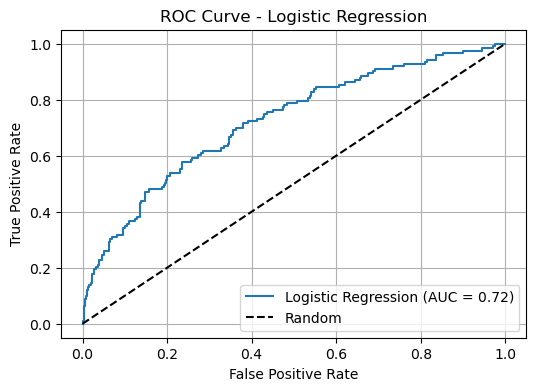

In [ ]:
# Evaluate all models - Logistic Regression

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# custom ROC Curve 
def plot_custom_roc_curve(model, X_test, y_test, model_name="Model"):
    y_probs = model.predict_proba(x_test)[:, 1]
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.figure(figsize=(6, 4))
    plt.plot(false_positive_rate, true_positive_rate, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


plot_custom_roc_curve(lr_model, x_test, y_test, "Logistic Regression")




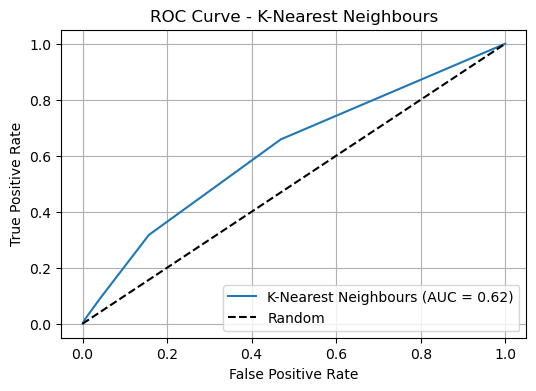

In [ ]:
# Evaluate all models - KNN 
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust later
knn_model.fit(x_train, y_train)

plot_custom_roc_curve(knn_model, x_test, y_test, "K-Nearest Neighbours")


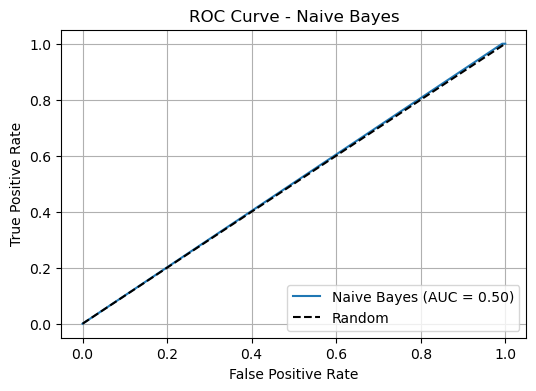

In [23]:
# Evaluate all models - Naive Bayes
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(x_train, y_train)

plot_custom_roc_curve(nb_model, x_test, y_test, "Naive Bayes")


In [ ]:
# model comparison

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=No

Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
Best Score (F1): 0.4100862308250844


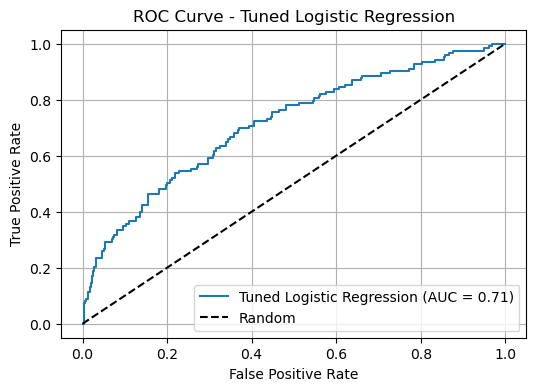


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.71      0.79       682
           1       0.26      0.57      0.36       123

    accuracy                           0.69       805
   macro avg       0.58      0.64      0.58       805
weighted avg       0.80      0.69      0.73       805


Key Metrics:
Recall: 0.569
Precision: 0.260
F1 Score: 0.357


In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Parameter grid for Logistic Regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2', 'elasticnet', None],  # Regularization type
    'solver': ['liblinear', 'saga'],  # Solver algorithms
    'class_weight': [None, 'balanced']  # Class weighting
}

# Note: 'liblinear' supports l1 and l2 penalties, while 'saga' supports all penalties
# Adjusting param grid to ensure compatibility between solver and penalty
param_grid = [
    # For liblinear solver
    {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'class_weight': [None, 'balanced']},
    
    # For saga solver
    {'solver': ['saga'], 'penalty': ['l1', 'l2', 'elasticnet', None], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'class_weight': [None, 'balanced']}
]

# Create the grid search with focus on F1 score
grid_search = GridSearchCV(
    estimator=LogisticRegression(max_iter=5000),  # Increased max_iter to ensure convergence
    param_grid=param_grid,
    scoring='f1',  # Or 'recall' if that's more important for your healthcare application
    cv=5,
    n_jobs=-1  # Use all available processors
)

# Fit the model
grid_search.fit(x_train, y_train)

# Print results
print("Best Parameters:", grid_search.best_params_)
print("Best Score (F1):", grid_search.best_score_)

# Evaluate on test set
best_log_reg = grid_search.best_estimator_
plot_custom_roc_curve(best_log_reg, x_test, y_test, "Tuned Logistic Regression")

# Calculate and print additional metrics for the best model
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score

y_pred = best_log_reg.predict(x_test)
y_prob = best_log_reg.predict_proba(x_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nKey Metrics:")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")